![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/Spark_NLP_Clinical_NER_Playground_Streamlit_app.ipynb)

# Spark NLP Clinical NER Playground - Streamlit app



### run the following the cell and upload your license keys

In [ ]:
import json, os
from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

### run the following cells and click on the ***ngrok url*** printed at the end (it may take a few minutes to load everything). It will open up a new tab on your browser to let you start play with the stremalit app.

In [2]:
%%capture

# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

! pip install spark-nlp-display
! pip install streamlit
! pip install pyngrok


In [3]:
%%writefile sparknlp_ner_playground.py

import streamlit as st
import pandas as pd
import base64

from sparknlp_display import NerVisualizer

st.sidebar.image('https://nlp.johnsnowlabs.com/assets/images/logo.png', use_column_width=True)

HTML_WRAPPER = """<div style="overflow-x: auto; border: 1px solid #e6e9ef; border-radius: 0.25rem; padding: 1rem; margin-bottom: 2.5rem">{}</div>"""

st.title("Spark NLP Clinical NER Playground")

import json
import os
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl
import sparknlp


import json

spark = sparknlp_jsl.start(os.environ['SECRET'])

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())


@st.cache(allow_output_mutation=True, suppress_st_warning=True)
def load_sparknlp_models():

    print ('loading pretrained models')

    sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
        .setInputCols(["document"])\
        .setOutputCol("sentence")

    embeddings_clinical = WordEmbeddingsModel.pretrained("embeddings_clinical","en","clinical/models")\
        .setInputCols(["sentence","token"])\
        .setOutputCol("embeddings")

    assertion = AssertionDLModel.pretrained("assertion_dl", "en", "clinical/models") \
        .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
        .setOutputCol("assertion")

    model_dict = {
        'sentenceDetector': sentenceDetector,
        'embeddings_clinical':embeddings_clinical,
        'assertion':assertion
            }
    
    for ner_model in ner_models_clinical:

      try:
        model_dict[ner_model] = MedicalNerModel.pretrained(ner_model,"en","clinical/models")\
                            .setInputCols(["sentence","token","embeddings"])\
                            .setOutputCol("ner")
      except:
        pass
        #st.write ('model name is wrong > ', ner_model)

    print ('models loaded !')

    return model_dict

ner_models_clinical = ['ner_jsl',
'ner_ade_clinical',
'ner_posology_large',
'ner_clinical_large',
'ner_deid_generic_augmented',
'ner_deid_subentity_augmented',
'ner_events_clinical',
'ner_radiology',
'ner_biomarker']

model_dict = load_sparknlp_models()


def display_time(start_tm):
    end_tm = time.time()
    diff = end_tm - start_tm
    st.write('<span style="color:red">{} sec</span>'.format(round(diff,4)), unsafe_allow_html=True)


def viz (annotated_text):

  raw_html = NerVisualizer().display(annotated_text, 'merged_chunks', return_html=True)
  sti = raw_html.find('<style>')
  ste = raw_html.find('</style>')+8
  st.markdown(raw_html[sti:ste], unsafe_allow_html=True)

  st.write(HTML_WRAPPER.format(raw_html[ste:]), unsafe_allow_html=True)


def get_table_download_link(df):
    
    """Generates a link allowing the data in a given panda dataframe to be downloaded
    in:  dataframe
    out: href string
    """
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode()).decode()  # some strings <-> bytes conversions necessary here
    href = f'<a href="data:file/csv;base64,{b64}">Download table as csv file</a>'
    st.write('')
    st.markdown(href, unsafe_allow_html=True)


def build_dynamic_pipeline(payload, embeddings_name='embeddings_clinical'):
    
    document = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

    sentence = model_dict['sentenceDetector']

    token = Tokenizer()\
        .setInputCols(['sentence'])\
        .setOutputCol('token')
        
    embeddings = model_dict[embeddings_name]

    st.write()

    ner_pipe = []

    for ner, entities in payload.items():
        
        first = len(ner_pipe) == 0
        
        ner_pipe.append(model_dict[ner]\
                .setInputCols(["sentence", "token", "embeddings"]) \
                .setOutputCol("{}_tags".format(ner))
                       )

        ner_pipe.append(NerConverterInternal()\
                  .setInputCols(["sentence", "token", "{}_tags".format(ner)])\
                  .setOutputCol("{}_chunks".format(ner))\
                  .setWhiteList(entities)
                           )
        

    ner_pipe.append(ChunkMergeApproach().\
                        setInputCols([i+'_chunks' for i in ner_models_clinical]).\
                        setOutputCol('merged_chunks'))
    
    ner_pipe.append(model_dict['assertion']\
                    .setInputCols(["sentence", "merged_chunks", "embeddings"])\
                    .setOutputCol("assertion"))
            
    ner_pipeline = Pipeline(
            stages = [
            document,
            sentence,
            token,
            embeddings]+ner_pipe)
    
    return ner_pipeline
    
st.sidebar.header('Select pretrained NER Model(s)')

st.sidebar.write('')

def get_labels(model):
    
    m = set(list([c.split('-')[1] for c in model.getClasses() if len(c)>1]))
    
    return list(m)

def get_payload():
    
    ner_payload =dict()
    
    for ner in ner_models_clinical:
    
        if ner=='clinical_ner':
            
            st.sidebar.checkbox(ner, value=True)
            
        if st.sidebar.checkbox(ner):

            classes = get_labels(model_dict[ner])

            concepts = st.sidebar.multiselect("entities in {}".format(ner), options=classes, default=classes)

            ner_payload[ner] = concepts
            
    return ner_payload

from sparknlp_display import NerVisualizer


def get_entities (ner_pipeline, text):
    
    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_model = ner_pipeline.fit(empty_data)

    light_model = LightPipeline(ner_model)

    full_annotated_text = light_model.fullAnnotate(text)[0]

    st.write('')
    st.subheader('Entities')

    chunks=[]
    entities=[]
    status = []

    for n,m in zip(full_annotated_text['merged_chunks'], full_annotated_text['assertion']):
        
        chunks.append(n.result)
        entities.append(n.metadata['entity']) 
        status.append(m.result)
            
    df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

    viz (full_annotated_text)
    
    st.table(df)
    
    return df



if st.sidebar.checkbox('Run all NERs'):
    
    st.sidebar.markdown("---")
    
    ner_payload = dict()

    concepts = []
    
    for ner in ner_models_clinical:

        classes = get_labels(model_dict[ner])

        ner_concepts = st.sidebar.multiselect("entities in {}".format(ner), options=classes, default=classes)

        ner_payload[ner] = ner_concepts
        
        concepts.extend(ner_concepts)

else:
    
    ner_payload = dict()

    for ner in ner_models_clinical:

        if st.sidebar.checkbox(ner):

            classes = get_labels(model_dict[ner])

            ner_concepts = st.sidebar.multiselect("entities in {}".format(ner), options=classes, default=classes)

            ner_payload[ner] = ner_concepts


ner_text = st.text_area('NER Input Text', 'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting. The patient was prescribed 1 capsule of Advil 10 mg for 5 days and magnesium hydroxide 100mg/1ml suspension PO. He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day .')

st.write (ner_text)

import time

start_time = time.time()

if len(ner_payload)!=0:
        
    st.markdown("**chunks will be merged if multiple models selected**")
    
    ner_pipeline = build_dynamic_pipeline (ner_payload)
    
    entities_df = get_entities (ner_pipeline, ner_text)
    
    get_table_download_link(entities_df )

    display_time(start_time)
    
    
# how to run
# streamlit run sparknlp_ner_playground.py --server.port 8503

Writing sparknlp_ner_playground.py


**You'd need a ngrok auth token at first.. You can get it at https://dashboard.ngrok.com/get-started/your-authtoken**

In [2]:
ngrok_token = "2FXsqDJRCR1ZktbBxYxrOcuXPIg_59izJC2g3nizSftfaAuBQ"

In [3]:
!ngrok authtoken $ngrok_token

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [4]:
!streamlit run /content/sparknlp_ner_playground.py --server.port 8503 &>/dev/null&

import time

time.sleep(3)

from pyngrok import ngrok

public_url = ngrok.connect(addr='8503')

print (public_url)

NgrokTunnel: "https://7fde-34-122-43-226.ngrok-free.app" -> "http://localhost:8503"


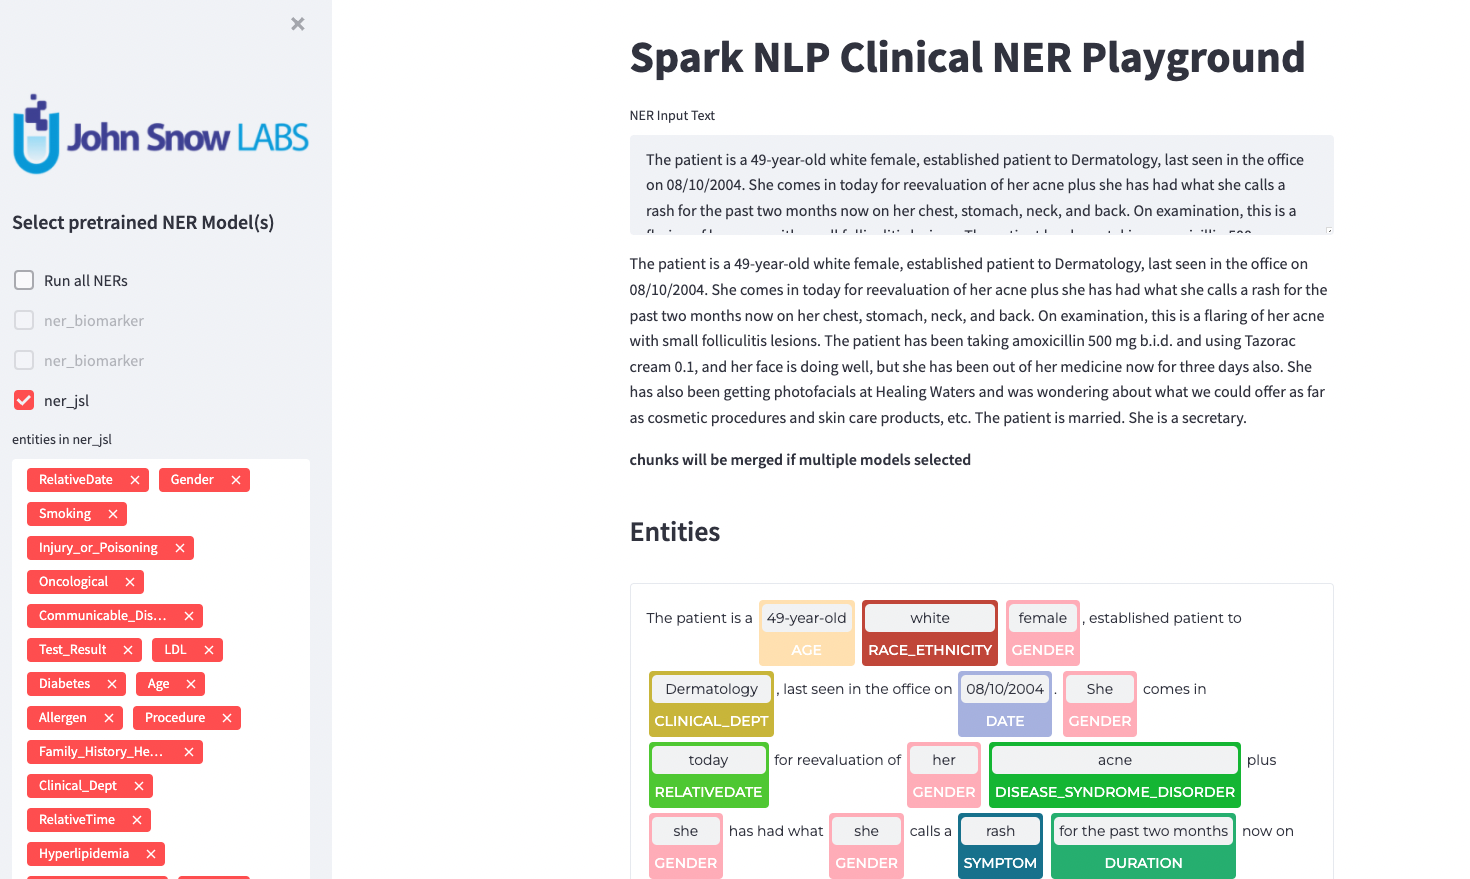

### if you want to kill the ngrok session and restart

In [5]:
!killall ngrok


In [ ]:
ngrok.get_tunnels()

[]

In [ ]:
public_url = ngrok.connect(addr='8503')

print (public_url)

NgrokTunnel: "http://5ccc-34-140-234-219.ngrok.io" -> "http://localhost:8503"
